### Описание проекта

Cтартап, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи  мобильного приложения.

Изучим воронку продаж. Узнаем, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследуем результаты A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/B-теста. Для него пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт лучше.


### Подготовим данные

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from matplotlib.ticker import FuncFormatter

In [2]:
logs = pd.read_csv('/datasets/logs_exp.csv',  delimiter='\t')

In [3]:
logs

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


#### Добавим столбец даты и времени, отдельный столбец дат и столбец дня:

In [4]:
logs['EventTimestamp'] = pd.to_datetime(logs['EventTimestamp'], unit = 's')

In [5]:
logs['data'] = logs['EventTimestamp'].dt.date

In [6]:
logs['data'] = pd.to_datetime(logs['data'])

In [7]:
logs['day'] = logs['data'].dt.day

#### Переименуем столбцы:

In [8]:
logs.columns = ['event', 'id', 'time', 'group', 'data', 'day']

#### Проверим пропуски, типы данных и дубликаты

In [9]:
print(logs.isnull().sum())

event    0
id       0
time     0
group    0
data     0
day      0
dtype: int64


Пропусков нет

In [10]:
logs.duplicated().sum()

413

Удалим дубликаты:

In [11]:
logs = logs.drop_duplicates()

Проверим типы данных:

In [12]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
event    243713 non-null object
id       243713 non-null int64
time     243713 non-null datetime64[ns]
group    243713 non-null int64
data     243713 non-null datetime64[ns]
day      243713 non-null int64
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 13.0+ MB


### Изучим и проверим данные

In [13]:
logs

,event,id,time,group,data,day
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,25
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07,7
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07,7
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07,7
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07,7


In [14]:
events = len(logs)
users = logs['id'].nunique()
avg_events = int(events / users)

In [15]:
print('Всего событий в логе:',events)
print('Всего пользователей в логе:',users)
print('В среднем событий приходится на пользователя:',avg_events)

Всего событий в логе: 243713
Всего пользователей в логе: 7551
В среднем событий приходится на пользователя: 32


In [16]:
print(logs['data'].max())
print(logs['data'].min())

2019-08-07 00:00:00
2019-07-25 00:00:00


Данные предоставлены с 25 июля по 7 августа 2019 года

In [17]:
day = logs.groupby('day').agg({'id': 'count'}).reset_index().sort_values('id', ascending = False)

In [18]:
day

,day,id
0,1,36141
4,5,36058
5,6,35788
1,2,35554
2,3,33282
3,4,32968
6,7,31096
13,31,2030
12,30,412
11,29,184


Text(0.5, 1.0, 'Гистограмма количества событий по дням')

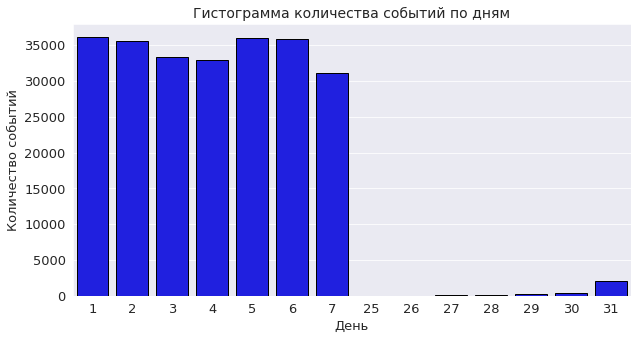

In [19]:
plt.figure(figsize=(10, 5))
sns.set_style("darkgrid")
plt.xticks(rotation=0)
plt.tick_params(axis='both', which='major', labelsize=13)
sns.barplot(x="day", y="id", color = 'blue', ec='black', data=day)
plt.xlabel('День',  fontsize='13')
plt.ylabel('Количество событий',  fontsize='13')
plt.title('Гистограмма количества событий по дням', fontsize=14)



Видим, что полные данные у нас есть только за период с 1 по 7 августа. Отбросим даты, по которым неполный набор данных:

In [20]:
logs_new = logs.query('data > "2019-07-31"')

In [21]:
events_new = len(logs_new)
users_new = logs_new['id'].nunique()

In [22]:
event_lose = events - events_new
users_lose = users - users_new

In [23]:
print('Всего событий потеряли:',event_lose)
print('Всего пользователей потеряли:',users_lose)

Всего событий потеряли: 2826
Всего пользователей потеряли: 17


#### Проверим, что у нас есть пользователи из всех трёх экспериментальных групп:

In [24]:
logs_new

,event,id,time,group,data,day
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01,1
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01,1
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01,1
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01,1
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01,1
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07,7
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07,7
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07,7
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07,7


In [25]:
group = logs_new.groupby('group').agg({'id': 'count'}).reset_index()

In [26]:
group

,group,id
0,246,79302
1,247,77022
2,248,84563


Присутсвуют данные о всех трех группах пользователей



### Изучим воронку событий

#### Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте

In [27]:
event = logs_new.groupby('event').agg({'id': 'count'}).sort_values('id', ascending = False).reset_index()

In [28]:
event

,event,id
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


Text(0.5, 1.0, 'Гистограмма количества событий по видам в логах ')

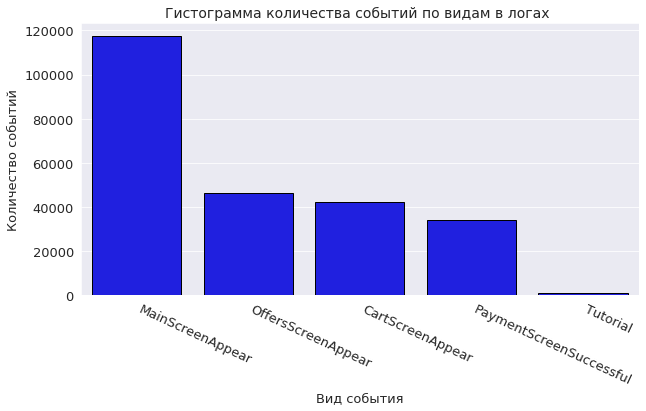

In [29]:
plt.figure(figsize=(10, 5))
sns.set_style("darkgrid")
plt.xticks(rotation=-25, ha='left')
plt.tick_params(axis='both', which='major', labelsize=13)
sns.barplot(x="event", y="id", color = 'blue', ec='black', data=event)
plt.xlabel('Вид события',  fontsize='13')
plt.ylabel('Количество событий',  fontsize='13')
plt.title('Гистограмма количества событий по видам в логах ', fontsize=14)

#### Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей

In [30]:
event_unique = logs_new.groupby('event').agg({'id': 'nunique'}).sort_values('id', ascending = False).reset_index()

In [31]:
event_unique

,event,id
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


Text(0.5, 1.0, 'Гистограмма количества событий по пользователям')

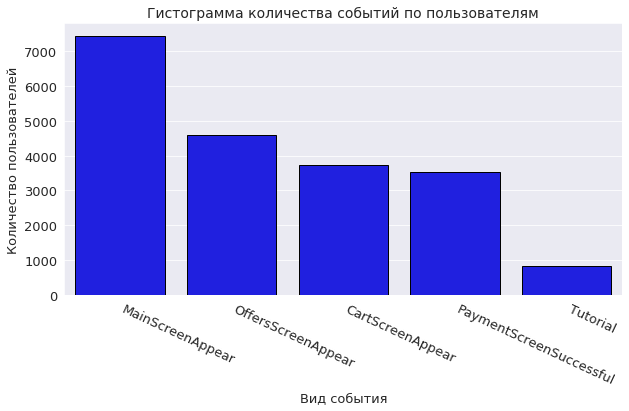

In [32]:
plt.figure(figsize=(10, 5))
sns.set_style("darkgrid")
plt.xticks(rotation=-25, ha='left')
plt.tick_params(axis='both', which='major', labelsize=13)
sns.barplot(x="event", y="id", color = 'blue', ec='black', data=event_unique)
plt.xlabel('Вид события',  fontsize='13')
plt.ylabel('Количество пользователей',  fontsize='13')
plt.title('Гистограмма количества событий по пользователям', fontsize=14)

#### Посчитаем долю пользователей, которые хоть раз совершали событие.

Примем число пользователей, которые прошли стадию появления главного экрана за 100% , исходя из этого вычислим долю пользователей, которые хоть раз совершали другие события

In [33]:
event_unique['share'] = (event_unique['id'] / 7419).round(2)

In [34]:
event_unique

,event,id,share
0,MainScreenAppear,7419,1.00
1,OffersScreenAppear,4593,0.62
2,CartScreenAppear,3734,0.50
3,PaymentScreenSuccessful,3539,0.48
4,Tutorial,840,0.11


##### Предпологаемый поряд событий:

- *MainScreenAppear* - появление главного экрана;
- *Tutorial* - прохождение обучения;
- *OffersScreenAppear* - предложение о товаре;
- *CartScreenAppear* - переход в корзину;
- *PaymentScreenSuccessful* - экран успешной оплаты.

Заметим, что этап Tutorial является не обязательным и не влияет на то, совершит ли пользователь покупку. Поэтому этот этап не нужно учитывать при расчёте воронки

In [35]:
logs_new = logs_new.query('event != "Tutorial"')

#### По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем)

Для начала для очищенных данных вновь посчитаем процент пользователей, которые хоть раз совершали событие

In [36]:
event_unique = logs_new.groupby('event').agg({'id': 'nunique'}).sort_values('id', ascending = False).reset_index()
event_unique['percent'] = ((event_unique['id'] / 7419)*100).round(1)

Найдем долю пользователей, которые проходят на следующий шаг воронки (от числа пользователей на предыдущем). Для этого напишем функцию

In [37]:
event_unique['%'] = ''

In [38]:
def ratio(row):
    event_unique.loc[0, '%'] = 100
    for i in range(len(event_unique)-2):  
        ratio = ((event_unique.loc[(i+1), 'id'] / event_unique.loc[i, 'id'])*100).round(1)
        event_unique.loc[(i+1), '%'] = ratio
     
    return row

 

In [39]:
event_unique = event_unique.apply(ratio)

In [40]:
event_unique

,event,id,percent,%
0,MainScreenAppear,7419,100.0,100
1,OffersScreenAppear,4593,61.9,61.9
2,CartScreenAppear,3734,50.3,81.3
3,PaymentScreenSuccessful,3539,47.7,


Можем заметить, что лишь всего 62% пользователей побывавших на первом этапе проходят  на второй этап. И меньше 50% от общего числа пользователей доходят до завершения покупки




### Изучим результаты эксперимента

#### Сколько пользователей в каждой экспериментальной группе?

In [41]:
group = logs_new.groupby('group').agg({'id': 'nunique'}).reset_index()

In [42]:
group

,group,id
0,246,2483
1,247,2512
2,248,2535


#### Проверим находят ли статистические критерии разницу между выборками

Выведем информацию по событиям по каждой группе:

In [43]:
users_by_events = logs_new.pivot_table(index = 'group',
                                   columns = 'event',
                                   values = 'id',
                                   aggfunc = 'nunique').reset_index()
users_by_events

event,group,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful
0,246,1266,2450,1542,1200
1,247,1238,2476,1520,1158
2,248,1230,2493,1531,1181


Добавим к  таблице столбец с количеством пользователей в каждой из групп:

In [44]:
users_count = logs_new.groupby('group')['id'].nunique()
users_by_events['users_count'] = users_by_events['group'].apply(lambda x: users_count.loc[x])
users_by_events = users_by_events.set_index('group')
users_by_events

event,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,users_count
group,,,,,
246,1266,2450,1542,1200,2483
247,1238,2476,1520,1158,2512
248,1230,2493,1531,1181,2535


Добавим группу 250 в которой совместим данные по группам 246 и 247

In [45]:
new_row = users_by_events.loc[246] + users_by_events.loc[247]
new_row.name = 250
users_by_events = users_by_events.append([new_row])

In [46]:
users_by_events

event,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,users_count
246,1266,2450,1542,1200,2483
247,1238,2476,1520,1158,2512
248,1230,2493,1531,1181,2535
250,2504,4926,3062,2358,4995


Проверим гипотезу о равенстве долей  при помощи Z-критерия. Для этого напишем функцию:

In [47]:
from scipy import stats as st
import numpy as np
import math as mth

In [48]:
def stat_z(group1, group2):
    for i in ['CartScreenAppear', 'MainScreenAppear', 'OffersScreenAppear', 'PaymentScreenSuccessful']:
        alpha = .05 
        successes = np.array([users_by_events.loc[group1, i], users_by_events.loc[group2, i]])
        trials = np.array([users_by_events.loc[group1, 'users_count'], users_by_events.loc[group2, 'users_count']])
        p1 = successes[0]/trials[0]
        p2 = successes[1]/trials[1]
        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
        difference = p1 - p2
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
        distr = st.norm(0, 1) 
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print("Событие:", i)
        print('p-значение: ', p_value.round(5))

        if (p_value < alpha):
                print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
                print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print()

#### Проведем сравнение двух А-групп (246 и 247) и убедимся, что тест был проведен корректно и между ними нет статистически значимых различий:

In [49]:
stat_z(246,247)

Событие: CartScreenAppear
p-значение:  0.22868
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: MainScreenAppear
p-значение:  0.75267
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение:  0.24786
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение:  0.11447
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



AA тест можно считать успешным. Различие ключевых метрик по группам не имеет статистической значимости



#### Посмотрим на результаты AB-теста
- А-группа: 246, В-группа: 248
- А-группа: 247, В-группа: 248
- А-группа: 250, В-группа: 248

##### А-группа: 246, В-группа: 248

In [50]:
stat_z(246,248)

Событие: CartScreenAppear
p-значение:  0.08067
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: MainScreenAppear
p-значение:  0.33871
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение:  0.21442
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение:  0.21693
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



##### А-группа: 247, В-группа: 248

In [51]:
stat_z(247,248)

Событие: CartScreenAppear
p-значение:  0.58783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: MainScreenAppear
p-значение:  0.5195
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение:  0.93338
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение:  0.72757
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



##### А-группа: 250, В-группа: 248

In [52]:
stat_z(250,248)

Событие: CartScreenAppear
p-значение:  0.18684
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: MainScreenAppear
p-значение:  0.34867
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение:  0.44583
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение:  0.61079
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



При изучении результатов эксперимента, мы провели 12 проверок статистических гипотез. В нашем случае из всех проведенных проверок не было обнаружено ниодного результата, который бы показал статистически значимых различий 



### Вывод

Мы убедились, что A/A-тест прошел успешно. Статистически значимых различий между двумя контрольными группами не обнаружено, это значит, что пользователи относятся к той или иной группе корректно. Если смотреть на результаты A/B-теста, то и там статистически значимых различий не было обнаружено, это говорит о том, что теория о том, что изменение шрифта в приложении может повлиять на метрики оказалась отвергнута. 